# **FOTS: Fast Oriented Text Spotting_3**


## **Importing Libraries**

In [ ]:
# mandatory libraries
import os
import numpy as np
import pandas as pd

#plotting libraries
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#computer vision libraries
import cv2
from PIL import Image,ImageDraw
from PIL import ImagePath

#file extracting libraries
from zipfile import ZipFile
import scipy.io

#miscellaneous libraries
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
import joblib
from scipy import stats
from shapely.geometry import Polygon
import datetime
from sklearn.model_selection import train_test_split

#Tensorflow libraries
import tensorflow as tf
from tensorflow.keras.layers import UpSampling2D,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras.layers import Activation, Flatten,Reshape,Input,MaxPooling2D
from tensorflow.keras.layers import Bidirectional,GRU,LSTM,Dense,Dropout,Lambda
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model


## **Mounting Google Drive**

In [ ]:
#mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## **Loading the saved .pkl files**

In [ ]:

icdar15_total=joblib.load('/content/gdrive/MyDrive/icdar15_gt_df.pkl.gz')

## **Pre-processing (remove don't care text)**

In [ ]:
def remove_dont_care_chars(bb_list,text_list):
    if len(bb_list)!=len(text_list):
        raise Exception("len of bounding box and text list are not equal")
    else:
        indices_star=np.where(text_list =="*")[0]
        indices_hash=np.where(text_list=="###")[0]
        indices=np.append(indices_star,indices_hash)
        if len(indices)!=0:
            new_text_list=np.delete(text_list,indices)
            new_bb_list=np.delete(bb_list,indices,axis=0)
        else:
            new_text_list=text_list
            new_bb_list=bb_list

        return new_bb_list,new_text_list

In [ ]:
new_bbox=[]
new_text=[]

for i, j in zip(icdar15_total['BBox'].values,icdar15_total['Text'].values):
    bb,text=remove_dont_care_chars(i,j)
    new_bbox.append(np.array(bb))
    new_text.append(np.array(text))   

icdar15_total['Text']=new_text
icdar15_total['BBox']=new_bbox

## **Downloading Datasets**

### **ICDAR-15**

Dataset link: https://rrc.cvc.uab.es/?ch=4&com=downloads

**Note:** you need to register in the above mentioned URL else you can't able to download the dataset.

In [ ]:
#images
!wget --header="Host: rrc.cvc.uab.es" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://rrc.cvc.uab.es/?ch=4&com=downloads" --header="Cookie: _ga=GA1.2.269986937.1624706527; PHPSESSID=mbdov6dmu2bkdu1kkgdn41f8c2; _gid=GA1.2.1278905833.1625080724; _gat=1" --header="Connection: keep-alive" "https://rrc.cvc.uab.es/downloads/ch4_training_images.zip" --no-check-certificate -c -O 'ch4_training_images.zip'

--2023-05-10 05:56:21--  https://rrc.cvc.uab.es/downloads/ch4_training_images.zip
Resolving rrc.cvc.uab.es (rrc.cvc.uab.es)... 158.109.8.55
Connecting to rrc.cvc.uab.es (rrc.cvc.uab.es)|158.109.8.55|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 90667586 (86M) [application/zip]
Saving to: ‘ch4_training_images.zip’

ch4_training_images 100%[===================>]  86.47M  7.08MB/s    in 29s     

2023-05-10 05:56:51 (2.94 MB/s) - ‘ch4_training_images.zip’ saved [90667586/90667586]



In [ ]:
#detection ground truths
!wget --header="Host: rrc.cvc.uab.es" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://rrc.cvc.uab.es/?ch=4&com=downloads" --header="Cookie: _ga=GA1.2.269986937.1624706527; PHPSESSID=mbdov6dmu2bkdu1kkgdn41f8c2; _gid=GA1.2.1278905833.1625080724" --header="Connection: keep-alive" "https://rrc.cvc.uab.es/downloads/ch4_training_localization_transcription_gt.zip" --no-check-certificate -c -O 'ch4_training_localization_transcription_gt.zip'

--2023-05-10 05:56:51--  https://rrc.cvc.uab.es/downloads/ch4_training_localization_transcription_gt.zip
Resolving rrc.cvc.uab.es (rrc.cvc.uab.es)... 158.109.8.55
Connecting to rrc.cvc.uab.es (rrc.cvc.uab.es)|158.109.8.55|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 344624 (337K) [application/zip]
Saving to: ‘ch4_training_localization_transcription_gt.zip’

ch4_training_locali 100%[===================>] 336.55K   297KB/s    in 1.1s    

2023-05-10 05:56:53 (297 KB/s) - ‘ch4_training_localization_transcription_gt.zip’ saved [344624/344624]



In [ ]:
#recognition ground truths
!wget --header="Host: rrc.cvc.uab.es" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://rrc.cvc.uab.es/?ch=4&com=downloads" --header="Cookie: _ga=GA1.2.269986937.1624706527; PHPSESSID=eni3jlh9srtnoeouf5mtvbtl8f; _gid=GA1.2.367952168.1626682752" --header="Connection: keep-alive" "https://rrc.cvc.uab.es/downloads/ch4_training_word_images_gt.zip" --no-check-certificate -c -O 'ch4_training_word_images_gt.zip'

--2023-05-10 05:56:53--  https://rrc.cvc.uab.es/downloads/ch4_training_word_images_gt.zip
Resolving rrc.cvc.uab.es (rrc.cvc.uab.es)... 158.109.8.55
Connecting to rrc.cvc.uab.es (rrc.cvc.uab.es)|158.109.8.55|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 41497737 (40M) [application/zip]
Saving to: ‘ch4_training_word_images_gt.zip’

ch4_training_word_i 100%[===================>]  39.58M  6.30MB/s    in 17s     

2023-05-10 05:57:10 (2.34 MB/s) - ‘ch4_training_word_images_gt.zip’ saved [41497737/41497737]



## **Extracting Files**

In [ ]:
def extract_images_from_zip_file(file_name,files_to_be_extracted,to_path=None):
    """function to extract required files from the zip file"""
    zpfile=ZipFile(file_name,'r')
    for f in files_to_be_extracted:
        zpfile.extract(f,path=to_path)
    zpfile.close()

In [ ]:
!mkdir /content/ICDAR_15
img_zip_file="/content/ch4_training_images.zip"
images=icdar15_total['Image'].values
extract_images_from_zip_file(img_zip_file,images,to_path="/content/ICDAR_15/")

In [ ]:
def change_image_path_icdar(data):
    return "ICDAR_15/"+data

In [ ]:
icdar15_total['Image']=icdar15_total['Image'].apply(change_image_path_icdar)

## **Functions to generate Ground Truths**

In [ ]:
def polygon_area(poly):
    '''
    compute area of a polygon
    '''
    edge = [
        (poly[1][0] - poly[0][0]) * (poly[1][1] + poly[0][1]),
        (poly[2][0] - poly[1][0]) * (poly[2][1] + poly[1][1]),
        (poly[3][0] - poly[2][0]) * (poly[3][1] + poly[2][1]),
        (poly[0][0] - poly[3][0]) * (poly[0][1] + poly[3][1])
    ]
    return np.sum(edge)/2.

In [ ]:
#based on the above tip, let us determine whether polygon points are valid or not
# if direction is not correct, let us make them into clock-wise as per requirement.
# ignoring the polygon whose area is less than 1 sq.px 

def check_and_validate_polys(polys, tags, h_w):

    """Given polys and tags with image height width, return the valid polys and coresponding tags"""
    
    (h, w) = h_w
    if polys.shape[0] == 0:
        return polys
    
    polys[:, :, 0] = np.clip(polys[:, :, 0], 0, w - 1)
    polys[:, :, 1] = np.clip(polys[:, :, 1], 0, h - 1)

    validated_polys = []
    validated_tags = []
    
    for poly, tag in zip(polys, tags):
        p_area = polygon_area(poly)
        
        if abs(p_area) < 1:
            continue
            
        if p_area > 0:
            poly = poly[(0, 3, 2, 1), :]
            
        validated_polys.append(poly)
        validated_tags.append(tag)
    return np.array(validated_polys), np.array(validated_tags)

In [ ]:
#below code is used to calculate the polygon vertices of the shrinked version 
#from the original polygon.i.e polgon for score map.
# it is described in the section 3.3.1 of EAST reasearch paper
#ref: - https://arxiv.org/pdf/1704.03155.pdf

def shrink_poly(poly, r):
    """Create shrinked poly for a given poly to produce score map"""
    
    R = 0.3 # shrink ratio
    # find the longer pair
    if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):

        # first move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)
        ## p0, p3
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
    else:
        ## p0, p3
        # print poly
        theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
        poly[0][0] += R * r[0] * np.sin(theta)
        poly[0][1] += R * r[0] * np.cos(theta)
        poly[3][0] -= R * r[3] * np.sin(theta)
        poly[3][1] -= R * r[3] * np.cos(theta)
        ## p1, p2
        theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
        poly[1][0] += R * r[1] * np.sin(theta)
        poly[1][1] += R * r[1] * np.cos(theta)
        poly[2][0] -= R * r[2] * np.sin(theta)
        poly[2][1] -= R * r[2] * np.cos(theta)
        ## p0, p1
        theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
        poly[0][0] += R * r[0] * np.cos(theta)
        poly[0][1] += R * r[0] * np.sin(theta)
        poly[1][0] -= R * r[1] * np.cos(theta)
        poly[1][1] -= R * r[1] * np.sin(theta)
        ## p2, p3
        theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
        poly[3][0] += R * r[3] * np.cos(theta)
        poly[3][1] += R * r[3] * np.sin(theta)
        poly[2][0] -= R * r[2] * np.cos(theta)
        poly[2][1] -= R * r[2] * np.sin(theta)

    return poly

In [ ]:
def point_dist_to_line(p1, p2, p3):
    """compute the distance from p3 to p1-p2"""
    
    return np.linalg.norm(np.cross(p2 - p1, p1 - p3)) / np.linalg.norm(p2 - p1)    

In [ ]:
#Find equation of line using two 2D points p1 and p2
def fit_line(p1, p2):
    '''fit a line ax+by+c = 0'''
    if p1[0] == p1[1]:
        return [1., 0., -p1[0]]
    else:
        [k, b] = np.polyfit(p1, p2, deg=1)
        return [k, -1., b]

In [ ]:
#Find Intersection poitn of 2 lines
def line_cross_point(line1, line2):
    '''line1 0= ax+by+c, compute the cross point of line1 and line2'''
    if line1[0] != 0 and line1[0] == line2[0]:
        print('Cross point does not exist')
        return None
    if line1[0] == 0 and line2[0] == 0:
        print('Cross point does not exist')
        return None
    if line1[1] == 0:
        x = -line1[2]
        y = line2[0] * x + line2[2]
    elif line2[1] == 0:
        x = -line2[2]
        y = line1[0] * x + line1[2]
    else:
        k1, _, b1 = line1
        k2, _, b2 = line2
        x = -(b1-b2)/(k1-k2)
        y = k1*x + b1
    return np.array([x, y], dtype=np.float32)

In [ ]:
#Get Equation of line that is perpendicular to line passing through a point
def line_verticle(line, point):
    '''get the verticle line from line across point'''
    if line[1] == 0:
        verticle = [0, -1, point[1]]
    else:
        if line[0] == 0:
            verticle = [1, 0, -point[0]]
        else:
            verticle = [-1./line[0], -1, point[1] - (-1/line[0] * point[0])]
    return verticle

In [ ]:
# Convert a parallelogram to rectangle
def rectangle_from_parallelogram(poly):
    '''
    fit a rectangle from a parallelogram
    '''
    p0, p1, p2, p3 = poly
    angle_p0 = np.arccos(np.dot(p1-p0, p3-p0)/(np.linalg.norm(p0-p1) * np.linalg.norm(p3-p0)))
    if angle_p0 < 0.5 * np.pi:
        if np.linalg.norm(p0 - p1) > np.linalg.norm(p0-p3):
            # p0 and p2
            ## p0
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p0)

            new_p3 = line_cross_point(p2p3, p2p3_verticle)
            ## p2
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p2)

            new_p1 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
        else:
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p0)

            new_p1 = line_cross_point(p1p2, p1p2_verticle)
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p2)

            new_p3 = line_cross_point(p0p3, p0p3_verticle)
            return np.array([p0, new_p1, p2, new_p3], dtype=np.float32)
    else:
        if np.linalg.norm(p0-p1) > np.linalg.norm(p0-p3):
            # p1 and p3
            ## p1
            p2p3 = fit_line([p2[0], p3[0]], [p2[1], p3[1]])
            p2p3_verticle = line_verticle(p2p3, p1)

            new_p2 = line_cross_point(p2p3, p2p3_verticle)
            ## p3
            p0p1 = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            p0p1_verticle = line_verticle(p0p1, p3)

            new_p0 = line_cross_point(p0p1, p0p1_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)
        else:
            p0p3 = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            p0p3_verticle = line_verticle(p0p3, p1)

            new_p0 = line_cross_point(p0p3, p0p3_verticle)
            p1p2 = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            p1p2_verticle = line_verticle(p1p2, p3)

            new_p2 = line_cross_point(p1p2, p1p2_verticle)
            return np.array([new_p0, p1, new_p2, p3], dtype=np.float32)

In [ ]:
#Sorting a rectangle to get all point in clockwies manner
def sort_rectangle(poly):
    '''sort the four coordinates of the polygon, points in poly should be sorted clockwise'''
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        # if angle <= 0:
        #     print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            #this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle

In [ ]:
def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    d = geometry[:, :4]
    angle = geometry[:, 4]
    # for angle > 0
    origin_0 = origin[angle >= 0]
    d_0 = d[angle >= 0]
    angle_0 = angle[angle >= 0]
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])


In [ ]:
#Some geometrical functions used in codes
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

In [ ]:
def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_


In [ ]:
#These Functions are used to Generate ROI params like out box,crop box & angles that we use to crop text from image
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

In [ ]:
def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

In [ ]:
#This function is used to generate geo_map,score_map, training_mask,corp_box,out_box,angle that we use while training model
def generate_rbox(im_size, polys, tags,num_classes):
    '''Genrate score_map and geo_map for image'''
    h, w = im_size
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    score_map = np.zeros((h, w), dtype=np.uint8)
    geo_map = np.zeros((h, w, 5), dtype=np.float32)

    outBoxs = []
    cropBoxs = []
    angles = []
    text_tags = []
    recg_masks = []
    # mask used during traning, to ignore some hard areas
    training_mask = np.ones((h, w), dtype=np.uint8)
    for poly_idx, poly_tag in enumerate(zip(polys, tags)):
        poly = poly_tag[0]
        #print(poly)
        tag = poly_tag[1]
        #print(tag)
        r = [None, None, None, None]
        for i in range(4):
            r[i] = min(np.linalg.norm(poly[i] - poly[(i + 1) % 4]),
                       np.linalg.norm(poly[i] - poly[(i - 1) % 4]))
        # score map
        shrinked_poly = shrink_poly(poly.copy(), r).astype(np.int32)[np.newaxis, :, :]
        cv2.fillPoly(score_map, shrinked_poly, 1)
        cv2.fillPoly(poly_mask, shrinked_poly, poly_idx + 1)

        # if geometry == 'RBOX':
        # generate a parallelogram for any combination of two vertices
        fitted_parallelograms = []
        for i in range(4):
            p0 = poly[i]
            p1 = poly[(i + 1) % 4]
            p2 = poly[(i + 2) % 4]
            p3 = poly[(i + 3) % 4]
            edge = fit_line([p0[0], p1[0]], [p0[1], p1[1]])
            backward_edge = fit_line([p0[0], p3[0]], [p0[1], p3[1]])
            forward_edge = fit_line([p1[0], p2[0]], [p1[1], p2[1]])
            if point_dist_to_line(p0, p1, p2) > point_dist_to_line(p0, p1, p3):
                #  parallel lines through p2
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p2[0]]
                else:
                    edge_opposite = [edge[0], -1, p2[1] - edge[0] * p2[0]]
            else:
                # after p3
                if edge[1] == 0:
                    edge_opposite = [1, 0, -p3[0]]
                else:
                    edge_opposite = [edge[0], -1, p3[1] - edge[0] * p3[0]]
            # move forward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p2 = line_cross_point(forward_edge, edge_opposite)
            if point_dist_to_line(p1, new_p2, p0) > point_dist_to_line(p1, new_p2, p3):
                # across p0
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p0[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p0[1] - forward_edge[0] * p0[0]]
            else:
                # across p3
                if forward_edge[1] == 0:
                    forward_opposite = [1, 0, -p3[0]]
                else:
                    forward_opposite = [forward_edge[0], -1, p3[1] - forward_edge[0] * p3[0]]
            new_p0 = line_cross_point(forward_opposite, edge)
            new_p3 = line_cross_point(forward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
            # or move backward edge
            new_p0 = p0
            new_p1 = p1
            new_p2 = p2
            new_p3 = p3
            new_p3 = line_cross_point(backward_edge, edge_opposite)
            if point_dist_to_line(p0, p3, p1) > point_dist_to_line(p0, p3, p2):
                # across p1
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p1[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p1[1] - backward_edge[0] * p1[0]]
            else:
                # across p2
                if backward_edge[1] == 0:
                    backward_opposite = [1, 0, -p2[0]]
                else:
                    backward_opposite = [backward_edge[0], -1, p2[1] - backward_edge[0] * p2[0]]
            new_p1 = line_cross_point(backward_opposite, edge)
            new_p2 = line_cross_point(backward_opposite, edge_opposite)
            fitted_parallelograms.append([new_p0, new_p1, new_p2, new_p3, new_p0])
        areas = [Polygon(t).area for t in fitted_parallelograms]
        parallelogram = np.array(fitted_parallelograms[np.argmin(areas)][:-1], dtype=np.float32)
        # sort thie polygon
        parallelogram_coord_sum = np.sum(parallelogram, axis=1)
        min_coord_idx = np.argmin(parallelogram_coord_sum)
        parallelogram = parallelogram[
            [min_coord_idx, (min_coord_idx + 1) % 4, (min_coord_idx + 2) % 4, (min_coord_idx + 3) % 4]]

        rectange = rectangle_from_parallelogram(parallelogram)
        rectange, rotate_angle = sort_rectangle(rectange)

        p0_rect, p1_rect, p2_rect, p3_rect = rectange

        # if the poly is too small, then ignore it during training
        poly_h = min(np.linalg.norm(p0_rect - p3_rect), np.linalg.norm(p1_rect - p2_rect))
        poly_w = min(np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p2_rect - p3_rect))

        invaild = (min(poly_h, poly_w) < 6) or tag is None or (True and poly_h > poly_w * 2)

        if invaild:
            cv2.fillPoly(training_mask, poly.astype(np.int32)[np.newaxis, :, :], 0)
        xy_in_poly = np.argwhere(poly_mask == (poly_idx + 1))
        
        if not invaild:
            roiRotatePara = generate_roiRotatePara(rectange, rotate_angle)
            if roiRotatePara:
                outBox, cropBox, angle = roiRotatePara
                if min(cropBox[2:]) > 6:
                    w , h = cropBox[2:]
                    textImgW = np.ceil(min(w / float(h) * 32, 256) / 4 /1)
                    #print(tag)
                    if textImgW >= 2 * min(len(tag), 16):  # avoid CTC error
                        outBoxs.append(outBox)
                        cropBoxs.append(cropBox)
                        angles.append(angle)
                        text_tags.append(tag[:16])
                        recg_masks.append(1.)

        for y, x in xy_in_poly:
            point = np.array([x, y], dtype=np.float32)
            # top
            geo_map[y, x, 0] = point_dist_to_line(p0_rect, p1_rect, point) + 3
            # right
            geo_map[y, x, 1] = point_dist_to_line(p1_rect, p2_rect, point) + 3
            # down
            geo_map[y, x, 2] = point_dist_to_line(p2_rect, p3_rect, point) + 3
            # left
            geo_map[y, x, 3] = point_dist_to_line(p3_rect, p0_rect, point) + 3
            # angle
            geo_map[y, x, 4] = rotate_angle
    if len(outBoxs) == 0:
        outBoxs.append([0, 0, 2 * 4, 2 * 4]) # keep extract From sharedConv feature map not zero
        cropBoxs.append([0, 0, 2 * 4, 2 * 4])
        angles.append(0.)
        text_tags.append([num_classes - 2])
        recg_masks.append(0.)

    outBoxs = np.array(outBoxs, np.int32)
    cropBoxs = np.array(cropBoxs, np.int32)
    angles = np.array(angles, np.float32)

    return score_map, geo_map, training_mask, (outBoxs, cropBoxs, angles), text_tags, recg_masks

In [ ]:
#Generator Function used to train Detection Branch in our Model
def generator(image_list,text_polys_list,text_tags_list,num_classes,
              input_size=512,batch_size=32):
    index = np.arange(0, len(image_list))
    while True:
        #np.random.shuffle(index)
        images = []
        image_fns = []
        score_maps = []
        geo_maps = []
        training_masks = []
        rboxes = []
        tags = []
        recg_masks = []
        for i in index:
            try:
                im_fn = image_list[i]
                
                im = cv2.imread(im_fn,cv2.IMREAD_UNCHANGED)
                
                # print im_fn
                h, w, _ = im.shape
                text_polys, text_tags = text_polys_list[i],text_tags_list[i]
                text_polys, text_tags = check_and_validate_polys(text_polys, text_tags, (h, w))
                
                
                #resize the image to input size
                new_h, new_w, _ = im.shape
                resize_h = input_size
                resize_w = input_size
                im = cv2.resize(im, dsize=(512, 512),interpolation = cv2.INTER_AREA)

                
                resize_ratio_3_x = resize_w/float(new_w)
                resize_ratio_3_y = resize_h/float(new_h)
                text_polys[:, :, 0] *= resize_ratio_3_x
                text_polys[:, :, 1] *= resize_ratio_3_y
                new_h, new_w, _ = im.shape
                score_map, geo_map, training_mask, rbox, text_tags, recg_mask = generate_rbox((new_h, new_w), text_polys, text_tags,num_classes)

                

                images.append(im)
                image_fns.append(im_fn)
                score_maps.append(score_map[::, ::, np.newaxis].astype(np.float32))
                geo_maps.append(geo_map[::, ::, :].astype(np.float32))
                training_masks.append(training_mask[::, ::, np.newaxis].astype(np.float32))
                
                
                
                rboxes.append(rbox)
                tags.append(text_tags)
                recg_masks.append(recg_mask)

                if len(images) == batch_size:
                    yield (np.array(images),np.concatenate([np.array(score_maps), np.array(geo_maps), np.array(training_masks)],axis=3))
                    images = []
                    image_fns = []
                    score_maps = []
                    geo_maps = []
                    training_masks = []
                    rboxes = []
                    tags = []
                    recg_masks = []
            except Exception as e:
                print(image_list[i])
                import traceback
                traceback.print_exc()
                continue

## **Data-Preparation for Recognition**

### **ICDAR-15**

Authors has provided the crop images and its corresponding word labels. So no need to crop images for ICDAR-15, like we did for Synth-Text dataset.

In [ ]:
!mkdir ./ICDAR_15_word_texts

mkdir: cannot create directory ‘./ICDAR_15_word_texts’: File exists


In [ ]:
!unzip -q "/content/ch4_training_word_images_gt.zip" -d "/content/ICDAR_15_word_texts/"

replace /content/ICDAR_15_word_texts/gt.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
icdar_text_images = pd.read_csv('/content/ICDAR_15_word_texts/gt.txt',
                         names=['path','word'],
                         delimiter=",")
icdar_text_images['word'] = icdar_text_images['word'].str.replace('"', '') # remove double quotes
icdar_text_images['path'] = icdar_text_images['path'].apply(lambda path:"ICDAR_15_word_texts/"+path)
icdar_text_images.sample(5)

,path,word
246,ICDAR_15_word_texts/word_247.png,Changi
4360,ICDAR_15_word_texts/word_4361.png,concierge
1095,ICDAR_15_word_texts/word_1096.png,GRE
139,ICDAR_15_word_texts/word_140.png,Shop
4176,ICDAR_15_word_texts/word_4177.png,MATCH


In [ ]:
icdar_text_images.shape
#we have 4.5k (approx) labels from ICDAR-15 dataset.

(4468, 2)

In [ ]:
# Save DataFrame to CSV file
icdar_text_images.to_csv('/content/gdrive/MyDrive/icdar_text_images.csv', index=False)

## **Modeling & Training**

In [ ]:
icdar_text_images = pd.read_csv("/content/gdrive/MyDrive/icdar_text_images.csv")
train_df,test_df=train_test_split(icdar_text_images,test_size=0.20,random_state=42)

In [153]:
print("Train - ",train_df.shape)
print("Test - ",test_df.shape)
icdar_text_images.shape[0]

Train -  (3574, 2)
Test -  (894, 2)


4468

In [ ]:
test_df.head(3)

,path,word
4173,ICDAR_15_word_texts/word_4174.png,GREAT
151,ICDAR_15_word_texts/word_152.png,that
3013,ICDAR_15_word_texts/word_3014.png,CAFE


In [135]:
# Generator for recognition training
def rec_generator(data, batch_size):
  """Generator function to produce input image and coresponding text vector"""
  while True:
    images = []
    texts_vec = []
    for i in range(data.shape[0]):
      try:
        path = data.iloc[i]['path']
        # Load image and save image matrix
        img = cv2.imread(path)
        img = cv2.detailEnhance(img)
        img = cv2.resize(img, (128,64),cv2.INTER_NEAREST)
        text = str(data.iloc[i]['word'])
        if len(text)==0:
          continue
        images.append(img)
        # Convert the text to vector
        text_vec = []
        for char in text:
          text_vec.append(char_to_index[char])
        # Maintaining constant size  
        while len(text_vec) < 25:
            text_vec.append(0)
        text_vec = np.array(text_vec)
        texts_vec.append(text_vec)
        if len(images) == batch_size:
          yield (np.array(images),np.array(texts_vec))
          images=[]
          texts_vec=[]
      except Exception as e:
        print('Error for: ', path)
        import traceback
        traceback.print_exc()
        continue

In [167]:
bs=1
train_gen=rec_generator(train_df,bs)
test_gen=rec_generator(test_df,bs)


In [172]:
chars = " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZÉ´-~`<>'.:;^/|!?$%#@&*()[]{}_+=,\\\""
n_classes = len(chars) 
char_to_index={}
index_to_char={}
for i,char in enumerate(chars):
  index_to_char[i+1]=char
  char_to_index[char]=i+1


In [173]:
icdar_text_images['word'].isnull().values.any()
#there are empty labels in the data-set.
#so then total length of vocab will be n_classes+2 (1 for empty label, 1 for unkown char)
#note: empty label is different from whitespace label.
icdar_text_images['word']

0        Genaxis Theatre
1                   [06]
2                  62-03
3                Carpark
4                   EXIT
              ...       
4463                 ONE
4464                 ar.
4465                play
4466          exclusives
4467                gest
Name: word, Length: 4468, dtype: object

### **Model Architecture**

In [139]:
def conv_bn_relu(input,n_filters,k_size=(3,3),strd=1,pad='same'):
    """function to do conv--> batch-norm-->Relu activation"""
    temp=input
    conv = Conv2D(filters=n_filters, kernel_size=k_size,
                  strides=strd, padding =pad,
                  activation = 'relu',
                  kernel_initializer = tf.keras.initializers.he_normal(seed=0))(temp)
    bn=BatchNormalization()(conv)
    relu=Activation('relu')(bn)

    return relu

In [140]:
# Recognition Model

input = Input(shape = (64,128,3), dtype='float32',name ='input')

x = conv_bn_relu(input,64,(3,3),1,'same')
x = MaxPool2D(pool_size = (2, 1),strides=(2,1),padding='same')(x)

x = conv_bn_relu(x,64,(3,3),1,'same')
x = MaxPool2D(pool_size = (2, 1),strides=(2,1),padding='same')(x)


x = conv_bn_relu(x,32,(3,3),1,'same')
x = conv_bn_relu(x,32,(3,3),1,'same')
x = MaxPool2D(pool_size = (2, 1),strides=(2,1),padding='same')(x)

x = conv_bn_relu(x,32,(3,3),1,'same')
x = conv_bn_relu(x,32,(3,3),1,'same')
x = MaxPool2D(pool_size = (2, 1),strides=(2,1),padding='same')(x)


x = conv_bn_relu(x,64,(3,3),1,'same')
x = Reshape(target_shape= ((64,-1)))(x)
x= Dense(64, activation='relu', kernel_initializer='he_normal')(x)


x= Dropout(rate=0.1)(x)
x = Bidirectional(LSTM(256,return_sequences=True,go_backwards=True))(x)


x= Dropout(rate=0.1)(x)
x = Bidirectional(LSTM(256,return_sequences=True,go_backwards=True))(x)


x= Dropout(rate=0.1)(x)
x = Bidirectional(LSTM(128,return_sequences=True,go_backwards=True))(x)


x= Dropout(rate=0.1)(x)
x = Dense(units=64,activation='relu',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(x)


x= Dropout(rate=0.1)(x)
out = Dense(units=n_classes+2,activation='softmax',
            kernel_initializer=tf.keras.initializers.glorot_normal(seed=0))(x)

recognizer=Model(input, out)

In [141]:
recognizer.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 64, 128, 3)]      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 128, 64)       1792      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 128, 64)      256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 64, 128, 64)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 128, 64)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 128, 64)       36928 

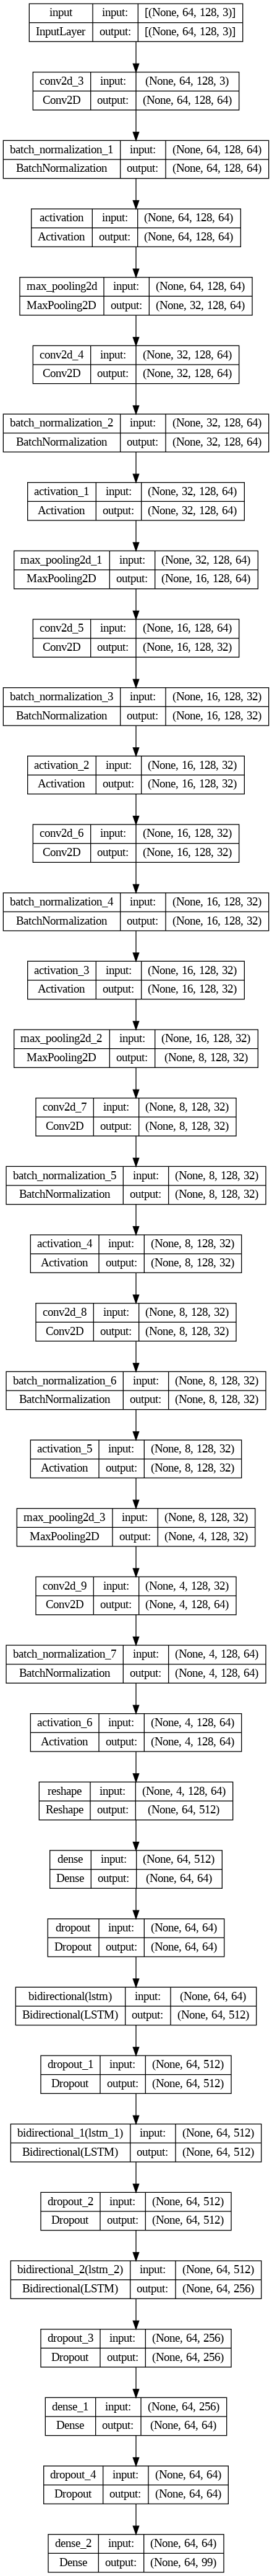

In [142]:
tf.keras.utils.plot_model(recognizer,show_shapes=True)

In [143]:
# Loss for recognition training
# https://stackoverflow.com/a/64334161
def ctc_loss(y_true,y_pred):
  label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)
  return tf.keras.backend.ctc_batch_cost(y_true, y_pred, np.ones((1,1),'int32')*64, label_length)

In [144]:
recognizer.compile(optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0),
                 loss=ctc_loss)

In [145]:
# define callbacks for learning rate scheduling and best checkpoints saving

filepath="/content/gdrive/MyDrive/Colab Notebooks/Case_Study_2/recognizer_1.h5"
log_dir="/content/gdrive/MyDrive/Colab Notebooks/Case_Study_2/Tensor_Board/fit/" +\
"recognizer_"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

Mdl_ckpt=ModelCheckpoint(filepath=filepath,save_best_only=True,
                         save_weights_only=True,mode='min', 
                         monitor='val_loss',verbose=1)
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                        histogram_freq=1, write_graph=True)
red_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,min_lr=1e-5,
                         patience=1,verbose=1,mode='min')
early=EarlyStopping(monitor='val_loss',patience=4,mode='min',verbose=1)

In [146]:
rec_history=recognizer.fit(train_gen,epochs=20,
            steps_per_epoch=int(np.ceil(len(train_df['word'].values)/bs)),
             validation_data=test_gen,
              validation_steps=int(np.ceil(len(test_df['word'].values)/bs)),
              callbacks=[Mdl_ckpt,red_lr,tensorboard_callback,early])

Epoch 1/20
3573/3574 [============================>.] - ETA: 0s - loss: 23.0335
Epoch 1: val_loss improved from inf to 21.92733, saving model to /content/gdrive/MyDrive/Colab Notebooks/Case_Study_2/recognizer_1.h5
3574/3574 [==============================] - 233s 39ms/step - loss: 23.0312 - val_loss: 21.9273 - lr: 0.0010
Epoch 2/20
3574/3574 [==============================] - ETA: 0s - loss: 21.7619
Epoch 2: val_loss did not improve from 21.92733

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3574/3574 [==============================] - 134s 38ms/step - loss: 21.7619 - val_loss: 27.9845 - lr: 0.0010
Epoch 3/20
3574/3574 [==============================] - ETA: 0s - loss: 21.1145
Epoch 3: val_loss did not improve from 21.92733

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
3574/3574 [==============================] - 133s 37ms/step - loss: 21.1145 - val_loss: 22.3679 - lr: 1.0000e-04
Epoch 4/20
3573/3574 [=====================

In [ ]:
recognizer.load_weights("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_2/recognizer_1.h5")

## **Inference functions**


In [ ]:
def sort_poly(p):
    """function to sort polygons"""
    min_axis = np.argmin(np.sum(p, axis=1))
    p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
    if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
        return p
    else:
        return p[[0, 3, 2, 1]]

In [ ]:
def intersection(g, p):
    """calculation intersection and union for IOU"""
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union

In [ ]:
def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g

In [ ]:
def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]

In [ ]:
def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
  
    for g in polys:
        if p is not None and intersection(g, p) > thres:
        
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
  
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    
    return standard_nms(np.array(S), thres)

In [ ]:
def total_inference(img):
  '''This function is main complete pipeline of our Model'''
  
  #1.Text Detection
  img=cv2.resize(img,(512,512))
  ii=detector.predict(np.expand_dims(img,axis=0))
  score_map=ii[0][:,:,0]
  geo_map=ii[0][:,:,1:]
  for ind in [0,1,2,3,4]:
    geo_map[:,:,ind]*=score_map

  #2.ROI Rotate  
  score_map_thresh=0.5
  box_thresh=0.1 
  nms_thres=0.2
  if len(score_map.shape) == 4:
    score_map = score_map[0, :, :, 0]
    geo_map = geo_map[0, :, :, :]

  # filter the score map
  xy_text = np.argwhere(score_map > score_map_thresh)

  # sort the text boxes via the y axis
  xy_text = xy_text[np.argsort(xy_text[:, 0])]

  # restore
  text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
  boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
  boxes[:, :8] = text_box_restored.reshape((-1, 8))
  boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
  boxes = nms_locality(boxes.astype(np.float64), nms_thres)
  

  # here we filter some low score boxes by the average score map, this is different from the orginal paper
  for i, box in enumerate(boxes):
    mask = np.zeros_like(score_map, dtype=np.uint8)
    cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32), 1)
    boxes[i, 8] = cv2.mean(score_map, mask)[0]
    if i==4:
      break
  if len(boxes)>0:
    boxes = boxes[boxes[:, 8] > box_thresh]
  boxes[:,:8:2] = np.clip(boxes[:,:8:2], 0, 512 - 1)
  boxes[:,1:8:2] = np.clip(boxes[:,1:8:2], 0, 512 - 1)  
  res = []
  result = []
  if len(boxes)>0:
    for box in boxes:
      box_ =  box[:8].reshape((4, 2))
      if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
        continue
      result.append(box_)
  res.append(np.array(result, np.float32))   

  box_index = []
  brotateParas = []
  filter_bsharedFeatures = []
  for i in range(len(res)):
    rotateParas = []
    rboxes=res[i]
    txt=[]
    for j, rbox in enumerate(rboxes):
      para = restore_roiRotatePara(rbox)
      if para and min(para[1][2:]) > 8:
        rotateParas.append(para)
        box_index.append((i, j))
    pts=[]   
    
    
    #3. Text Recognition (From boxes given by Text Detection+ROI Rotate) 
    if len(rotateParas) > 0:
      for num in range(len(rotateParas)):
        text=""
        out=rotateParas[num][0]
        crop=rotateParas[num][1]
        points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
        angle=rotateParas[num][2] 
        img1=tf.image.crop_to_bounding_box(img,out[1],out[0],out[3],out[2])
        img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
        img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
        img2=cv2.resize(img2,(128,64))
        img2=cv2.detailEnhance(img2)
        ii=recognizer.predict(np.expand_dims(img2,axis=0))
        arr=tf.keras.backend.ctc_decode(ii,np.ones((1),'int8')*64,)
        for val in arr[0][0].numpy()[0]:
          if val==-1:
            break
          else:
            text+=index_to_char[val]
        txt.append(text)
        pts.append(points)
    
    # 4. Labeling detected and Recognized Text in Image  
    for i in range(len(txt)):
      cv2.polylines(img,[pts[i]],isClosed=True,color=(0,255,0),thickness=1)
      cv2.putText(img,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,1, (0,250,0),2)  
    return img,txt

## **Total Inference ( Detection + Recognition)**

In [ ]:


# Create custom DConv layer having upsample, conv and bn layers

class Deconv(tf.keras.layers.Layer):
    
    def __init__(self, name="Deconv", **kwargs):
        super().__init__(name=name, **kwargs)
        self.inp_shape = 0
        self.upsample = None
        self.conv = None
        self.bn = None
        
    def build(self,imshape):
        self.inp_shape=imshape
        self.upsample=UpSampling2D(size=(2,2),interpolation='bilinear',
                                   data_format='channels_last',)
        self.conv=Conv2D(filters=self.inp_shape[-1]//2,kernel_size=3,
                         padding='same',activation='relu',
                         kernel_initializer=tf.keras.initializers.glorot_normal(seed=32),
                         kernel_regularizer=tf.keras.regularizers.l2(1e-5), 
                         use_bias=False)
        self.bn=BatchNormalization()
   
    def call(self,X):
    
        x=self.upsample(X)
        x=self.conv(x)
        x=self.bn(x)
        return x

In [ ]:
# Detection Branch - Modeling with pretrained ResNet50 and Deconv layer

# Shared network 

resnet=tf.keras.applications.ResNet50(input_shape=(512,512,3),
                                      include_top=False,
                                      weights='imagenet')
tf.keras.backend.clear_session()

for layers in resnet.layers:
     layers.trainable=False



x = resnet.get_layer('conv5_block3_out').output

x = Deconv('Deconv1')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv4_block6_out').output])

x = Deconv('Deconv2')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv3_block4_out').output])

x = Deconv('Deconv3')(x)
x = tf.keras.layers.add([x,resnet.get_layer('conv2_block3_out').output])

# --- end ---

# text detector specific
x=BatchNormalization()(x)
x = Deconv('Deconv4')(x)
x = Deconv('Deconv5')(x)

score=Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(x)

# Used this beacause sigmoid gives values in range of 0-1(as mentioned in git repository)
geo_map=Conv2D(4,kernel_size=3,padding='same',activation='sigmoid')(x)*512

# Angles are assumed to be between [-45 to 45]
angle_map=(Conv2D(1,kernel_size=3,padding='same',activation='sigmoid')(x)-0.5)*np.pi/2

out=tf.concat([score,geo_map,angle_map],axis=3)

detector=tf.keras.Model(resnet.input,out,name='detector')

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
#Loss for Detection-Branch

class Detection_Loss(tf.keras.losses.Loss):
    
    def __init__(self, from_logits=False,
                 reduction=tf.keras.losses.Reduction.AUTO,
                 name='Detection_Loss'):
        super(Detection_Loss, self).__init__(reduction=reduction, name=name)

    
    # Dice coefficient loss for score maps
    def dice_coefficient(self, y_true_cls, y_pred_cls,training_mask):
        """Classification Loss as Dice loss
        Given score maps (y_true and y_pred) & training mask,
        this function computes dice loss"""

        eps = 10**-6 # small epsilon value to handle no-intersection cases.

        intersection = tf.reduce_sum(y_true_cls * y_pred_cls * training_mask)

        union = tf.reduce_sum(y_true_cls * training_mask) + \
        tf.reduce_sum(y_pred_cls * training_mask) + eps
        cl_loss = 1. - (2 * intersection / union)
        return cl_loss


    # IOU loss for geomaps
    def rbox_loss(self, y_true_cls,y_true_geo,y_pred_geo,training_mask):
        """Given score and geo maps, it computes IOU loss and rotation angle loss and returns the total loss"""

        # d1 -> top, d2->right, d3->bottom, d4->left
        d1_gt, d2_gt, d3_gt, d4_gt, theta_gt = tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)
        d1_pred, d2_pred, d3_pred, d4_pred, theta_pred = tf.split(value=y_pred_geo, num_or_size_splits=5, axis=3)

        area_gt = (d1_gt + d3_gt) * (d2_gt + d4_gt)
        area_pred = (d1_pred + d3_pred) * (d2_pred + d4_pred)
        w_union = tf.minimum(d2_gt, d2_pred) + tf.minimum(d4_gt, d4_pred)
        h_union = tf.minimum(d1_gt, d1_pred) + tf.minimum(d3_gt, d3_pred)
        area_intersect = w_union * h_union
        area_union = area_gt + area_pred - area_intersect

        L_AABB = -tf.math.log((area_intersect + 1.0) / (area_union + 1.0))
        L_theta = 1 - tf.cos(theta_pred - theta_gt)

        L_g = L_AABB +  50*L_theta
        L_g=tf.squeeze(L_g,axis=3)

        return tf.reduce_mean(L_g * y_true_cls * training_mask)


        
    def call(self, y_true, y_pred):

        #Extract geo_map and score_maps
        y_true_cls=y_true[:,:,:,0]
        y_pred_cls=y_pred[:,:,:,0]
        y_pred_geo=y_pred[:,:,:,1:6]
        y_true_geo=y_true[:,:,:,1:6]
        training_mask=y_true[:,:,:,6]

        #1. Dice Loss
        dice_loss = self.dice_coefficient(y_true_cls, y_pred_cls, training_mask)
        # we scale classification loss by factor of 0.01 to match the iou loss part
        dice_loss *=0.01

        #2. IOU and Rotation Angle loss
        rbox_loss_ = self.rbox_loss(y_true_cls,y_true_geo,y_pred_geo,training_mask)


        return 100*(rbox_loss_ + dice_loss)

In [ ]:
detector.compile(optimizer=Adam(learning_rate=5e-4,amsgrad=True),
                 loss=Detection_Loss())

In [ ]:
# detector.load_weights("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_2/detector_10k.h5")

In [ ]:
detector.load_weights("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_2/detector_10k_ICDAR.h5")

In [147]:
recognizer.load_weights("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_2/recognizer_1.h5")

In [148]:
def show_final_inference(images):
    """function to display original image Vs detection and recognition predicted images"""
    fig,axes=plt.subplots(2,len(images),figsize=(15,15))
    axes=axes.flatten()
    ax_idx=0    
    for count in range(2):
        for img in images:
            axes[ax_idx].set_title("Original Image")
            i = cv2.imread(img)
            i=cv2.resize(i,(512,512))
            i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
            if (count ==1):
                i = cv2.imread(img)
                i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
                i,t=total_inference(i)
                axes[ax_idx].set_title("Predicted Image with Bounding Boxes")            
            axes[ax_idx].imshow(i)
            ax_idx+=1
    plt.show()

1/1 [==============================] - 0s 32ms/step


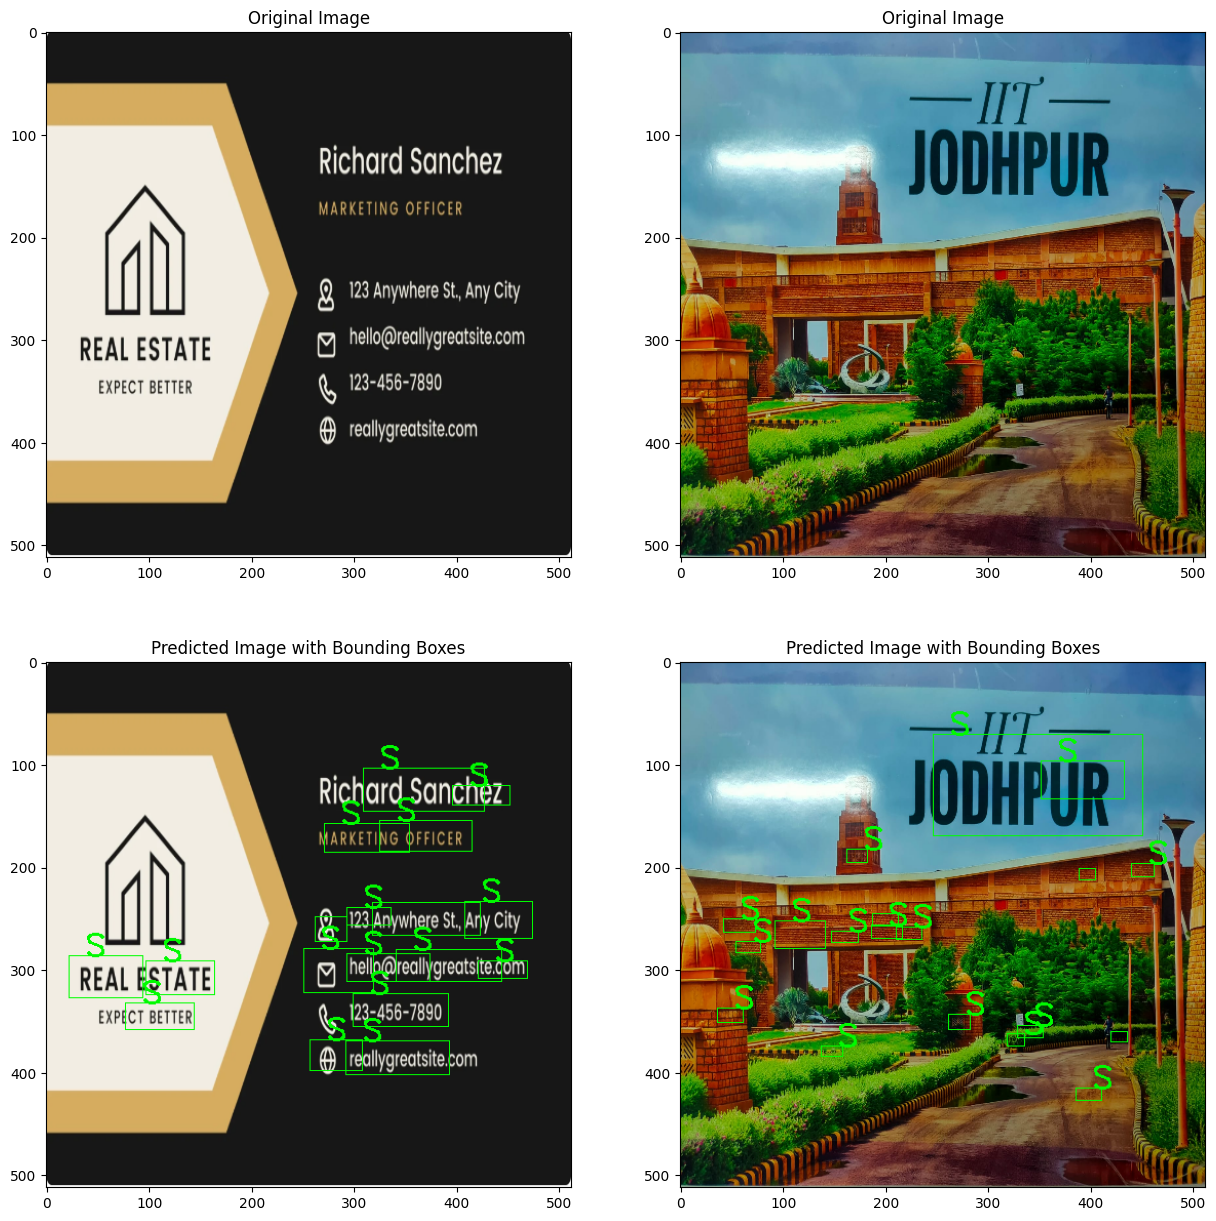

In [176]:
def show_final_inference(image_paths):
    """function to display original image Vs detection and recognition predicted images"""
    fig,axes=plt.subplots(2,len(image_paths),figsize=(15,15))
    axes=axes.flatten()
    ax_idx=0    
    for count in range(2):
        for img_path in image_paths:
            axes[ax_idx].set_title("Original Image")
            i = cv2.imread(img_path)
            i=cv2.resize(i,(512,512))
            i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
            if (count ==1):
                i = cv2.imread(img_path)
                i = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
                i,t=total_inference(i)
                axes[ax_idx].set_title("Predicted Image with Bounding Boxes")            
            axes[ax_idx].imshow(i)
            ax_idx+=1
    plt.show()

# Example usage:
img_paths = ["/Business Card.PNG", "/iitJ.jpeg"]
show_final_inference(img_paths)


1/1 [==============================] - 0s 27ms/step


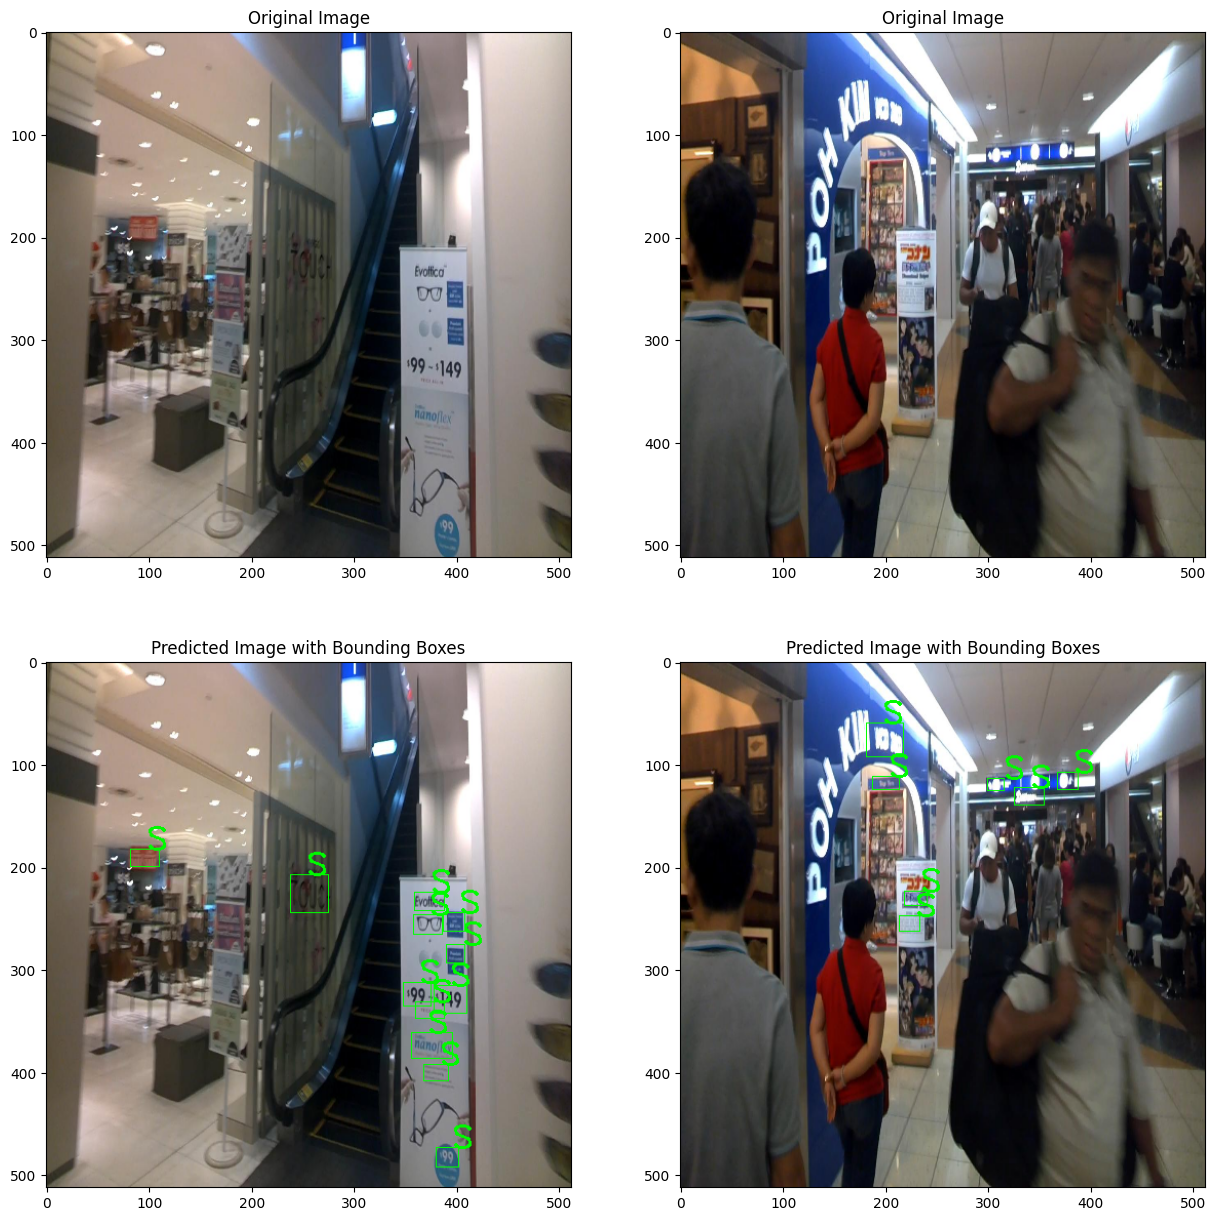

In [178]:
img_path=np.random.choice(icdar15_total['Image'].values,2)
show_final_inference(img_path)

In [ ]:
detector.load_weights("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_2/detector_10k.h5")

**Conclusion**

1) Detection Branch is predicting conditionally good. Its performance can be enhanced by training whith complete dataset (we have considered only 10k data points for training).

2) Recognition Branch is not performing that good. This is because we have considered only 10k images out of 800k images for training.